### Laplace approximation

- Laplace's method approximates a Bayesian posterior distribution with normal distribution.
- If the "true distribution"  $f(\cdot)$  actually comes from the same family of distributions of our model  $\mathcal{M}$, then the "true distribution" should have a fixed unique parameter  $\theta_0$. We expect our posterior distribution to approach  $\theta_0$  as  $n$  the number of samples increase. If $f(\cdot)$ is not part of the same distribution as our model, then we expect that there is a unique value $\theta_0$ in our model that minimizes the KL divergence between our model and the true distribution.
    - Anyways, we'll have a unique MAP estimate as $n \rightarrow \infty$.

- **Theorem 1**: If the parameter space  $\Theta$  is finite and  $P(\theta = \theta_0) > 0$  (prior is non-zero at  $\theta_0$ ), then  $P(\theta=\theta_0 | y) \rightarrow 1$  as  $n \rightarrow \infty$ , where  $\theta_0$  is the value that uniquely minimizes the KL divergence.
- **Theorem 2** (Bernstein-von Mises Theorem): Under some regularity conditions, as  $n \rightarrow \infty$ , the posterior distribution of  $\theta$  approaches normality with mean  $\theta_0$  and variance  $(nI(\theta_0))^{-1}$ , where  $\theta_0$  is the value that minimized the KL divergence and $I$ is the **Fisher information**.


- $\hat{\theta}$: the posterior mode. 
- $\hat{\theta} \rightarrow \theta_0$ as $n \rightarrow \infty$
- We can approximate the log posterior density using a Taylor approximation up to the quadratic term centered at the posterior mode, which when translated back to a non-log scale is a normal distribution. This technique is called Laplace's Method.

$$
\begin{align}
log\,P(\theta|y) &\approx log\,P(\hat{\theta}) + (\theta - \hat{\theta}) \frac{d}{d\theta}[log\,P(\theta|y)]_{\theta=\hat{\theta}} \\
&\quad\qquad\qquad + \frac{1}{2}(\theta - \hat{\theta})^2 \frac{d^2}{d\theta^2}[log\,P(\theta|y)]_{\theta=\hat{\theta}}  \\
&= log\,P(\hat{\theta}) + \frac{1}{2}(\theta - \hat{\theta})^2 \frac{d^2}{d\theta^2}[log\,P(\theta|y)]_{\theta=\hat{\theta}}  \\
&= const + \frac{1}{2}(\theta - \hat{\theta})^2 \frac{d^2}{d\theta^2}[log\,P(\theta|y)]_{\theta=\hat{\theta}}  \\
&= const - \frac{1}{2}\frac{(\theta - \mu)^2}{\sigma^2} \\
\tag{5}
\end{align}
$$

The first order term, $(\theta - \hat{\theta}) \frac{d}{d\theta}[log\,P(\theta|y)]_{\theta=\hat{\theta}} =0$ because it is a mode.
<br>where, $\mu = \hat{\theta}$ and $\sigma^2 = -(\frac{d^2}{d\theta^2}[log\,P(\theta|y)]_{\theta=\hat{\theta}})^{-1}$

The inner expression of the latter is just the observed information, which is approximately  $nI(\hat{\theta})$ for large  n , where  I is the Fisher Information.

Finally,
$$
\begin{align}
log\,P(\theta|y) &\approx  log\,P(\hat{\theta}) + \frac{1}{2}(\theta - \hat{\theta})^2 \frac{d^2}{d\theta^2}[log\,P(\theta|y)]_{\theta=\hat{\theta}} \\ &= const - \frac{1}{2}\frac{(\theta - \hat{\theta})^2}{(nI(\hat{\theta}))^{-1}} \\ P(\theta|y) &\approx exp\{C - \frac{(\theta - \hat{\theta})^2}{2(nI(\hat{\theta}))^{-1}}\} \\ &= N(\hat{\theta}, (nI(\hat{\theta}))^{-1}) \tag{8}
\end{align}
$$

#### Implementations: Poisson Data with a Gamma Prior

<img src=attachment:image.png width=600>
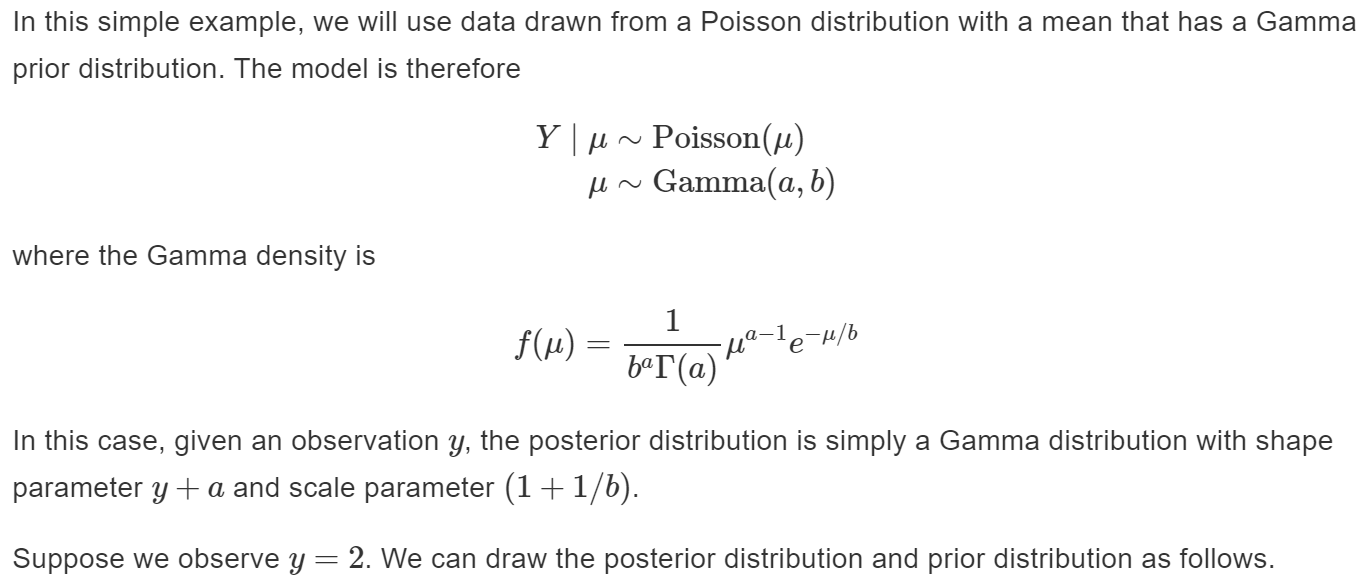

- After a single observation $y=2$, the gamma prior over $\mu$ changes to the posterior, which is another gamma.
- You see the mode of posterior is around 3, because of the prior.

In [1]:
library('repr')
options(repr.plot.width=5, repr.plot.height=4)

In [2]:
# dgamma : return pdf of gamma

make_post <- function(y, shape, scale) {
        function(x) {
                dgamma(x, shape = y + shape,
                       scale = 1 / (1 + 1 / scale))
        }
}

y <- 2
prior.shape <- 3
prior.scale <- 3
p <- make_post(y, prior.shape, prior.scale)

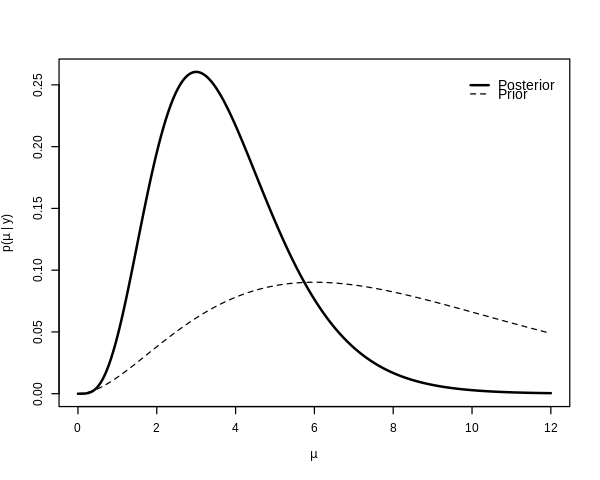

In [3]:
op <- par(cex = 0.6)
curve(p, 0, 12, n = 1000, lwd = 2, xlab = expression(mu),
      ylab = expression(paste("p(", mu, " | y)")))
curve(dgamma(x, shape = prior.shape, scale = prior.scale), add = TRUE,
      lty = 2)

op <- par(cex = 0.7)
legend('topright',inset=c(0.05,0.05), legend = c("Posterior", "Prior"), lty = c(1, 2), lwd = c(2, 1), bty = "n")

- gamma distribution with a shape parameter $k$ and a scale parameter $\theta$.
    - mean = $k\theta$
    - mode = $(k-1)\theta$

In [4]:
pmode <- (y + prior.shape - 1) * (1 / (1 + 1 / prior.scale))
pmode

[1] 3

In [5]:
pmean <- (y + prior.shape) * (1 / (1 + 1 / prior.scale))
pmean

[1] 3.75

We can compute the gradient and Hessian of the Gamma density.

In [6]:
a <- prior.shape
b <- prior.scale
fhat <- deriv3(~ mu^(y + a - 1) * exp(-mu * (1 + 1/b)) / ((1/(1+1/b))^(y+a) * gamma(y + a)), "mu", function.arg = TRUE)

Then we can compute the quadratic approximation to the density.

In [7]:
post.shape <- y + prior.shape - 1
post.scale <- 1 / (length(y) + 1 / prior.scale)
lapprox <- Vectorize(function(mu, mu0 = pmode) {
        deriv <- fhat(mu0)
        grad <- attr(deriv, "gradient")
        hess <- drop(attr(deriv, "hessian"))
        f <- function(x) dgamma(x, shape = post.shape, scale = post.scale)
        hpp <- (hess * f(mu0) - grad^2) / f(mu0)^2
        exp(log(f(mu0)) + 0.5 * hpp * (mu - mu0)^2)
}, "mu")

Plotting the true posterior and the Laplace approximation.

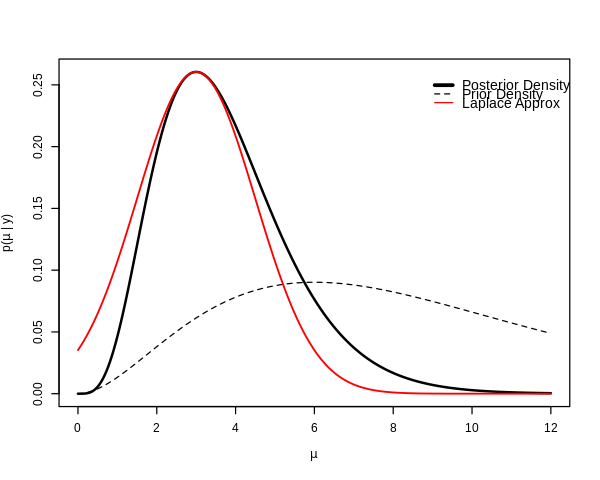

In [8]:
op <- par(cex = 0.6)
curve(p, 0, 12, n = 1000, lwd = 2, xlab = expression(mu),
      ylab = expression(paste("p(", mu, " | y)")))
curve(dgamma(x, shape = prior.shape, scale = prior.scale), add = TRUE,
      lty = 2)
curve(lapprox, 0.001, 12, n = 1000, add = TRUE, col = 2, lwd = 1.5)

op <- par(cex = 0.7)
legend("topright", inset=c(0.05,0.05),
       legend = c("Posterior Density", "Prior Density", "Laplace Approx"), 
       lty = c(1, 2, 1), lwd = c(3, 1, 1), col = c(1, 1, 2), bty = "n")

- Note 
    -  The Laplace approximation is likely to work well when the posterior is unimodal and relatively symmetric around the model. Furthermore, the more concentrated the posterior is around $\hat{\theta}$, the better.